# ETL Processes
Use this notebook to develop the ETL process for each of your tables before completing the `etl.py` file to load the whole datasets.

In [125]:
import os
import glob
import psycopg2
import pandas as pd
from IPython.display import Image
from sql_queries import *
from tqdm import tqdm

In [126]:
conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
cur = conn.cursor()

In [127]:
def get_files(filepath):
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.json'))
        for f in files :
            all_files.append(os.path.abspath(f))
    
    return all_files

In [128]:
def process_data(cur, conn, filepath, func):
    # get all files matching extension from directory
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.json'))
        for f in files :
            all_files.append(os.path.abspath(f))

    # get total number of files found
    num_files = len(all_files)
    print('{} files found in {}'.format(num_files, filepath))

    with tqdm(total=num_files) as pbar:
        for i, datafile in enumerate(all_files, 1):
            func(cur, datafile)
            conn.commit()
            pbar.update(1)
#             print('{}/{} files processed.'.format(i, num_files))


---
---
# Process `song_data`
In this first part, you'll perform ETL on the first dataset, `song_data`, to create the `songs` and `artists` dimensional tables.

Let's perform ETL on a single song file and load a single record into each table to start.
- Use the `get_files` function provided above to get a list of all song JSON files in `data/song_data`
- Select the first song in this list
- Read the song file and view the data

In [129]:
song_files = get_files('data/song_data')

In [130]:
print('{} records'.format(len(song_files)))

71 records


In [131]:
filepath = song_files[0]

In [132]:
filepath

'/home/workspace/data/song_data/A/A/C/TRAACER128F4290F96.json'

In [133]:
df = pd.read_json(filepath, lines=True)
df.head()

,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,num_songs,song_id,title,year
0,ARMAC4T1187FB3FA4C,40.82624,"Morris Plains, NJ",-74.47995,The Dillinger Escape Plan,207.77751,1,SOBBUGU12A8C13E95D,Setting Fire to Sleeping Giants,2004


---
## #1: `songs` Table

#### 1.1 &mdash; Extract Data for Songs Table
- Select columns for song ID, title, artist ID, year, and duration
- Use `df.values` to select just the values from the dataframe
- Index to select the first (only) record in the dataframe
- Convert the array to a list and set it to `song_data`

In [134]:
df.values.tolist()

[['ARMAC4T1187FB3FA4C',
  40.82624,
  'Morris Plains, NJ',
  -74.47995,
  'The Dillinger Escape Plan',
  207.77751,
  1,
  'SOBBUGU12A8C13E95D',
  'Setting Fire to Sleeping Giants',
  2004]]

In [135]:
song_df = df[['song_id', 'title', 'artist_id', 'year', 'duration']]
first_song_record = song_df.values[0].tolist()

assert isinstance(first_song_record, list), 'first_song_record should be a list'
first_song_record

['SOBBUGU12A8C13E95D',
 'Setting Fire to Sleeping Giants',
 'ARMAC4T1187FB3FA4C',
 2004,
 207.77751]

In [136]:
# verify that record matches dataframe

song_df

,song_id,title,artist_id,year,duration
0,SOBBUGU12A8C13E95D,Setting Fire to Sleeping Giants,ARMAC4T1187FB3FA4C,2004,207.77751


#### 1.2 &mdash; Insert a single song record into Song Table
Implement the `song_table_insert` query in `sql_queries.py` and run the cell below to insert a record for this song into the `songs` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `songs` table in the sparkify database.

In [137]:
# preview query (to verify column order)

song_table_insert

'\n    INSERT INTO songs (song_id, title, artist_id, year, duration)\n    VALUES (%s, %s, %s, %s, %s)\n    ON CONFLICT (song_id) \n    DO UPDATE \n    SET title=EXCLUDED.title, artist_id=EXCLUDED.artist_id, year=EXCLUDED.year, duration=EXCLUDED.duration\n'

In [138]:
# insert first song record

cur.execute(song_table_insert, first_song_record)
conn.commit()

Run `test.ipynb` to see if you've successfully added a record to this table.

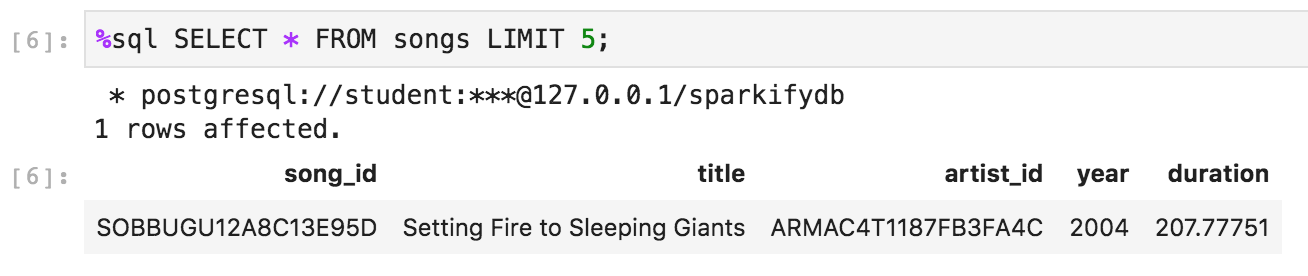

In [139]:
# verify insertion via test.ipynb and display results

Image(filename='images/etl_song_insert_confirmation.png', width=650)

#### 1.3 &mdash; Insert all song records into Song Table

In [140]:
# incorporate steps above into a song processing function

def process_song_file(cur, filepath):
    # create dataframe
    df = pd.read_json(filepath, lines=True)
    
    # extract song values
    song_record = df[['song_id', 'title', 'artist_id', 'year', 'duration']].values[0].tolist()
    
    # insert first song record
    cur.execute(song_table_insert, song_record)
    conn.commit()


In [141]:
# insert all song records

process_data(cur, conn, filepath='data/song_data', func=process_song_file)

 11%|█▏        | 8/71 [00:00<00:00, 73.06it/s]

71 files found in data/song_data


100%|██████████| 71/71 [00:00<00:00, 88.19it/s]


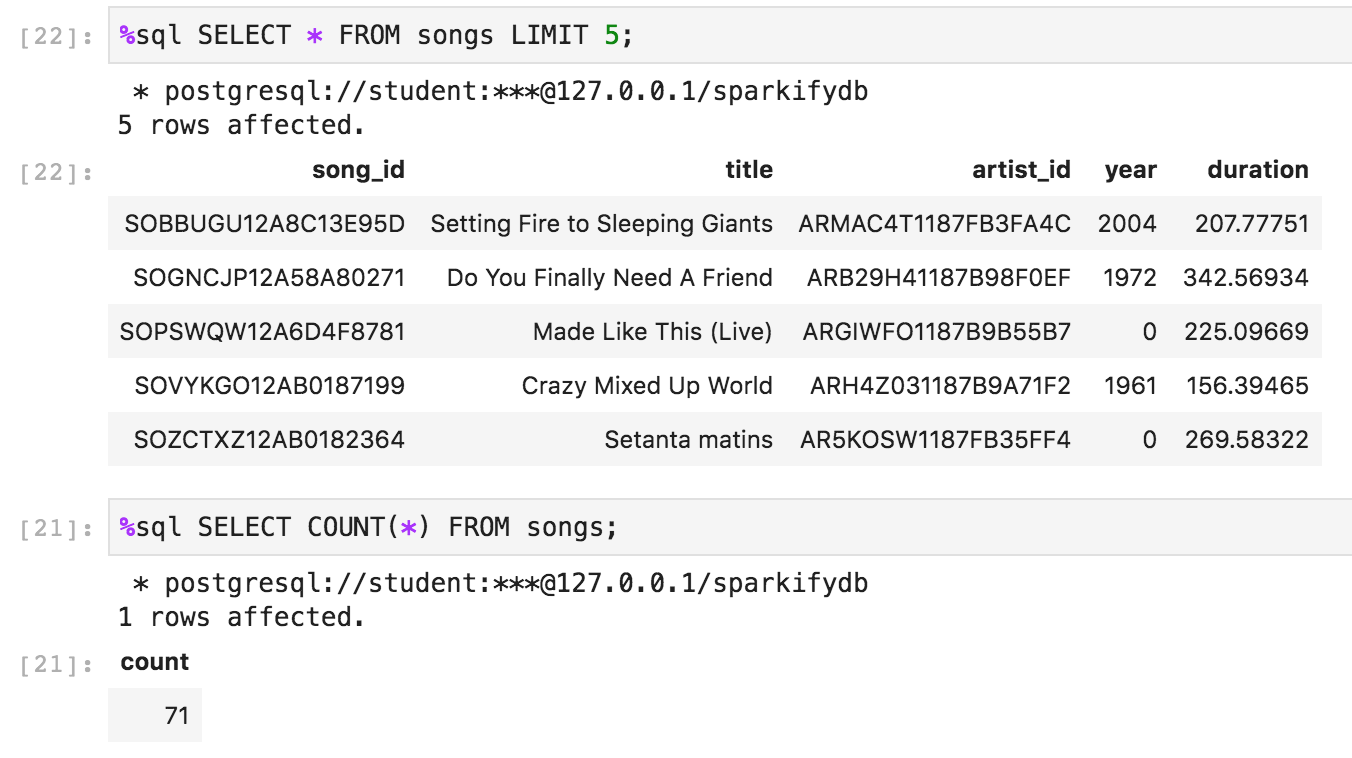

In [142]:
# verify insertion via test.ipynb and display results

Image(filename='images/etl_songs_insert_all_confirmation.png', width=650)

---
## #2: `artists` Table

#### 2.1 &mdash; Extract Data for Artists Table
- Select columns for artist ID, name, location, latitude, and longitude
- Use `df.values` to select just the values from the dataframe
- Index to select the first (only) record in the dataframe
- Convert the array to a list and set it to `artist_data`

In [143]:
artist_df = df[['artist_id', 'artist_name', 'artist_location', 'artist_latitude', 'artist_longitude']]
artist_record = artist_df.values[0].tolist()

# display results
artist_df.head()

,artist_id,artist_name,artist_location,artist_latitude,artist_longitude
0,ARMAC4T1187FB3FA4C,The Dillinger Escape Plan,"Morris Plains, NJ",40.82624,-74.47995


In [144]:
artist_record

['ARMAC4T1187FB3FA4C',
 'The Dillinger Escape Plan',
 'Morris Plains, NJ',
 40.82624,
 -74.47995]

#### 2.2 &mdash; Insert a single record into Artist Table
Implement the `artist_table_insert` query in `sql_queries.py` and run the cell below to insert a record for this song's artist into the `artists` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `artists` table in the sparkify database.

In [145]:
# preview query (to verify column order)
artist_table_insert

'\n    INSERT INTO artists (artist_id, name, location, latitude, longitude)\n    VALUES (%s, %s, %s, %s, %s)\n    ON CONFLICT (artist_id) \n    DO UPDATE \n    SET name=EXCLUDED.name, location=EXCLUDED.location, latitude=EXCLUDED.latitude, longitude=EXCLUDED.longitude \n'

In [146]:
cur.execute(artist_table_insert, artist_record)
conn.commit()

Run `test.ipynb` to see if you've successfully added a record to this table.

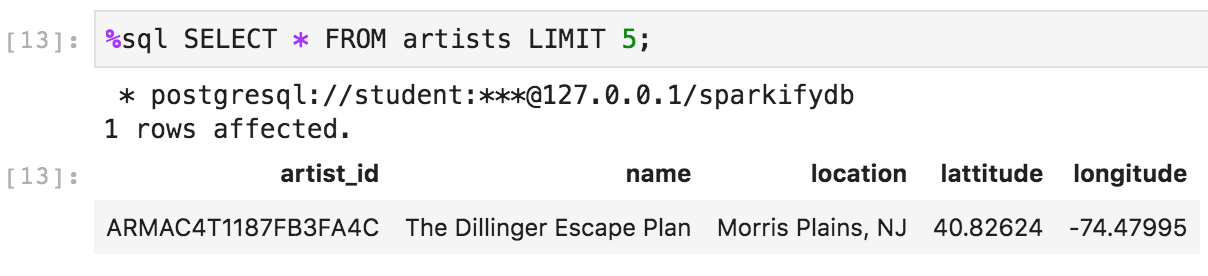

In [147]:
# verify via test.ipynb and display output

Image(filename='images/etl_artist_insert_confirmation.png', width=600)

#### 2.3 &mdash; Insert all artist records into Artist Table


In [148]:
# incorporate steps above into an artist processing function

def process_artist_file(cur, filepath):
    # create dataframe
    df = pd.read_json(filepath, lines=True)
    
    # extract song values
    artist_record = df[['artist_id', 'artist_name', 'artist_location', 'artist_latitude', 'artist_longitude']].values[0].tolist()
    
    # insert first song record
    cur.execute(artist_table_insert, artist_record)
    conn.commit()


In [149]:
# insert all song records

process_data(cur, conn, filepath='data/song_data', func=process_artist_file)

 13%|█▎        | 9/71 [00:00<00:00, 88.64it/s]

71 files found in data/song_data


100%|██████████| 71/71 [00:00<00:00, 96.18it/s]


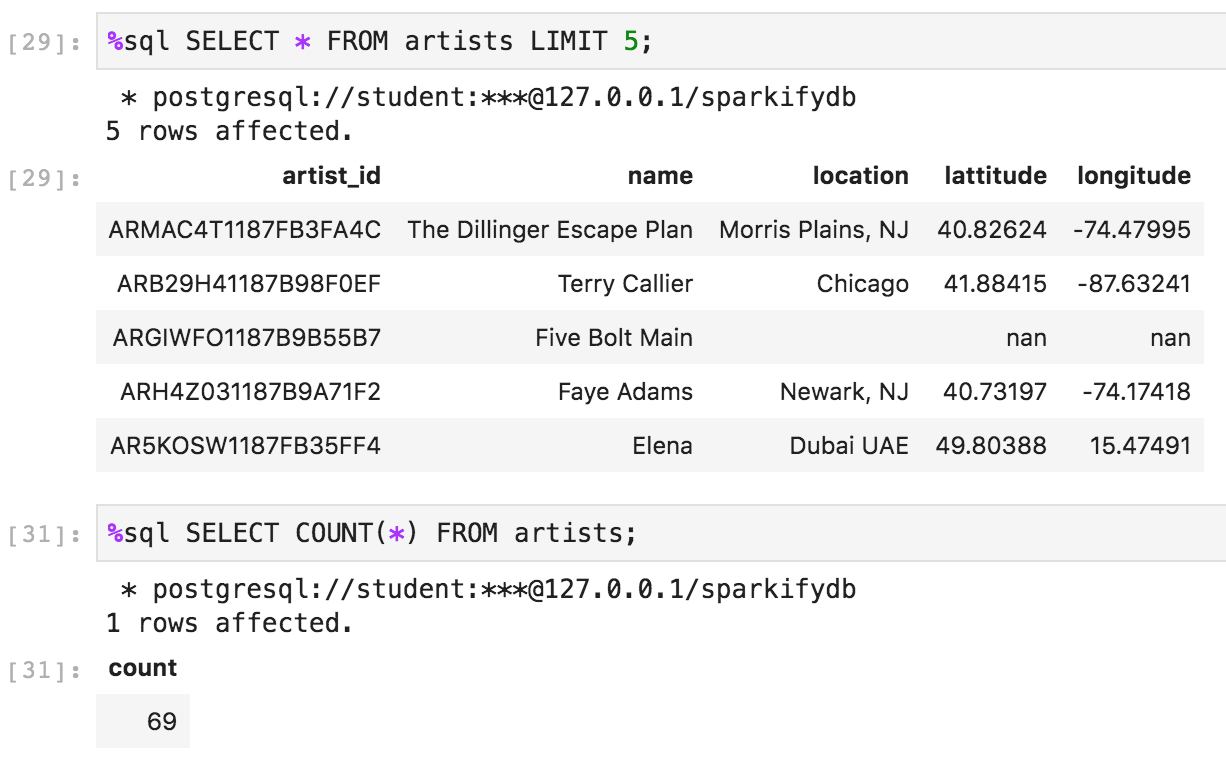

In [150]:
# verify insertion via test.ipynb and display results

Image(filename='images/etl_artists_insert_all_confirmation.png', width=600)

---
---
# Process `log_data`
In this part, you'll perform ETL on the second dataset, `log_data`, to create the `time` and `users` dimensional tables, as well as the `songplays` fact table.

Let's perform ETL on a single log file and load a single record into each table.
- Use the `get_files` function provided above to get a list of all log JSON files in `data/log_data`
- Select the first log file in this list
- Read the log file and view the data

In [151]:
log_files = get_files('data/log_data')
print('{} records'.format(len(log_files)))

30 records


In [152]:
log_files[0]

'/home/workspace/data/log_data/2018/11/2018-11-12-events.json'

In [153]:
filepath = log_files[0]

In [154]:
print(filepath)

/home/workspace/data/log_data/2018/11/2018-11-12-events.json


In [155]:
log_df = pd.read_json(filepath, lines=True)
print('{} records'.format(len(log_df)))
log_df.head()

213 records


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Celeste,F,0,Williams,NaN,free,"Klamath Falls, OR",GET,Home,1.541078e+12,438,None,200,1541990217796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
1,Pavement,Logged In,Sylvie,F,0,Cruz,99.16036,free,"Washington-Arlington-Alexandria, DC-VA-MD-WV",PUT,NextSong,1.540266e+12,345,Mercy:The Laundromat,200,1541990258796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
2,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Logged In,Celeste,F,1,Williams,277.15873,free,"Klamath Falls, OR",PUT,NextSong,1.541078e+12,438,Horn Concerto No. 4 in E flat K495: II. Romanc...,200,1541990264796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
3,Gary Allan,Logged In,Celeste,F,2,Williams,211.22567,free,"Klamath Falls, OR",PUT,NextSong,1.541078e+12,438,Nothing On But The Radio,200,1541990541796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
4,None,Logged In,Jacqueline,F,0,Lynch,NaN,paid,"Atlanta-Sandy Springs-Roswell, GA",GET,Home,1.540224e+12,389,None,200,1541990714796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",29


---
## #3: `time` Table
### Extract Data for Time Table
1. Filter records by `NextSong` action
1. Convert the `ts` timestamp column to datetime
  - Hint: the current timestamp is in milliseconds
1. Extract the timestamp, hour, day, week of year, month, year, and weekday from the `ts` column and set `time_data` to a list containing these values in order
  - Hint: use pandas' [`dt` attribute](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) to access easily datetimelike properties.
1. Specify labels for these columns and set to `column_labels`
1. Create a dataframe, `time_df,` containing the time data for this file by combining `column_labels` and `time_data` into a dictionary and converting this into a dataframe

#### 3.1 &mdash; Filter records by NextSong action

In [156]:
# count records for page!=NextSong for later verification
not_next_song_df = log_df.loc[log_df['page'] != "NextSong"]

# preview results
print('{} records'.format(len(not_next_song_df)))
not_next_song_df.head()

47 records


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Celeste,F,0,Williams,NaN,free,"Klamath Falls, OR",GET,Home,1.541078e+12,438,None,200,1541990217796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
4,None,Logged In,Jacqueline,F,0,Lynch,NaN,paid,"Atlanta-Sandy Springs-Roswell, GA",GET,Home,1.540224e+12,389,None,200,1541990714796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",29
13,None,Logged In,Kimber,F,0,Norris,NaN,free,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1.540976e+12,412,None,200,1542000167796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",47
14,None,Logged In,Lily,F,0,Burns,NaN,free,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1.540621e+12,466,None,200,1542001320796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",32
15,None,Logged In,Lily,F,1,Burns,NaN,free,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1.540621e+12,466,None,200,1542001337796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",32


In [157]:
# filter by NextSong and verify record count
next_song_df = log_df.loc[log_df['page'] == "NextSong"].reindex()

# preview results
print('{} records'.format(len(next_song_df)))
next_song_df.head()

166 records


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
1,Pavement,Logged In,Sylvie,F,0,Cruz,99.16036,free,"Washington-Arlington-Alexandria, DC-VA-MD-WV",PUT,NextSong,1.540266e+12,345,Mercy:The Laundromat,200,1541990258796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
2,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Logged In,Celeste,F,1,Williams,277.15873,free,"Klamath Falls, OR",PUT,NextSong,1.541078e+12,438,Horn Concerto No. 4 in E flat K495: II. Romanc...,200,1541990264796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
3,Gary Allan,Logged In,Celeste,F,2,Williams,211.22567,free,"Klamath Falls, OR",PUT,NextSong,1.541078e+12,438,Nothing On But The Radio,200,1541990541796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
5,Charttraxx Karaoke,Logged In,Celeste,F,3,Williams,225.17506,free,"Klamath Falls, OR",PUT,NextSong,1.541078e+12,438,Fireflies,200,1541990752796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
6,The Libertines,Logged In,Jacqueline,F,1,Lynch,179.53914,paid,"Atlanta-Sandy Springs-Roswell, GA",PUT,NextSong,1.540224e+12,389,The Good Old Days,200,1541990842796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",29


##### Record count verification

#### 3.2 &mdash; Convert the ts timestamp column to datetime

In [158]:
import datetime

t = pd.to_datetime(next_song_df.ts, unit='ms')

# preview results
print('{} records'.format(len(t)))
t.head()

166 records


1   2018-11-12 02:37:38.796
2   2018-11-12 02:37:44.796
3   2018-11-12 02:42:21.796
5   2018-11-12 02:45:52.796
6   2018-11-12 02:47:22.796
Name: ts, dtype: datetime64[ns]

#### 3.3 &mdash; Extract the timestamp, hour, day, week of year, month, year, and weekday from the ts column and set time_data to a list containing these values in order

In [159]:
time_data = [t, t.dt.hour, t.dt.day, t.dt.weekofyear, t.dt.month, t.dt.year, t.dt.day_name()]

#### 3.4 &mdash; Specify labels for these columns and set to column_labels

In [160]:
column_labels = ['ts', 'hour', 'day', 'week of year', 'month', 'year', 'weekday']

assert isinstance(time_data, list), 'time_data should be a list'
assert isinstance(column_labels, list), 'column_labels should be a list'

#### 3.5 &mdash; Create a dataframe, time_df, containing the time data for this file by combining column_labels and time_data into a dictionary and converting this into a dataframe

In [161]:
dictionary = dict(zip(column_labels, time_data))
time_df = pd.DataFrame.from_dict(dictionary)

# preview results
print('{} records'.format(len(time_df)))
time_df.head()

166 records


,ts,hour,day,week of year,month,year,weekday
1,2018-11-12 02:37:38.796,2,12,46,11,2018,Monday
2,2018-11-12 02:37:44.796,2,12,46,11,2018,Monday
3,2018-11-12 02:42:21.796,2,12,46,11,2018,Monday
5,2018-11-12 02:45:52.796,2,12,46,11,2018,Monday
6,2018-11-12 02:47:22.796,2,12,46,11,2018,Monday


### Insert Records into Time Table
Implement the `time_table_insert` query in `sql_queries.py` and run the cell below to insert records for the timestamps in this log file into the `time` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `time` table in the sparkify database.

In [162]:
for i, row in time_df.iterrows():
    cur.execute(time_table_insert, list(row))
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

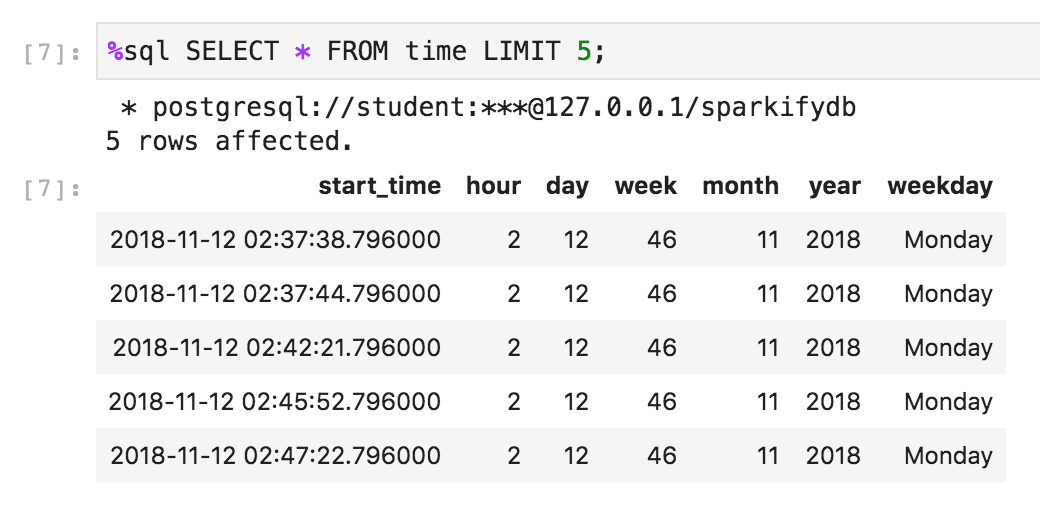

In [163]:
# display output from test.ipynb

Image(filename='images/etl_time_insert_confirmation.png', width=500)

---
## #4: `users` Table
#### Extract Data for Users Table
- Select columns for user ID, first name, last name, gender and level and set to `user_df`

In [164]:
user_df = next_song_df[['userId', 'firstName', 'lastName', 'gender', 'level']]

# preview results
print('{} records'.format(len(user_df)))
user_df.head()

166 records


,userId,firstName,lastName,gender,level
1,10,Sylvie,Cruz,F,free
2,53,Celeste,Williams,F,free
3,53,Celeste,Williams,F,free
5,53,Celeste,Williams,F,free
6,29,Jacqueline,Lynch,F,paid


#### Insert Records into Users Table
Implement the `user_table_insert` query in `sql_queries.py` and run the cell below to insert records for the users in this log file into the `users` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `users` table in the sparkify database.

In [165]:
user_df = user_df.drop_duplicates().sort_values(['userId'])

# preview results
print('{} records'.format(len(user_df)))
user_df

24 records


,userId,firstName,lastName,gender,level
1,10,Sylvie,Cruz,F,free
20,100,Adler,Barrera,M,free
177,12,Austin,Rosales,M,free
155,14,Theodore,Harris,M,free
40,26,Ryan,Smith,M,free
6,29,Jacqueline,Lynch,F,paid
52,32,Lily,Burns,F,free
121,33,Bronson,Harris,M,free
27,34,Evelin,Ayala,F,free
35,37,Jordan,Hicks,F,free


In [166]:
for i, row in user_df.iterrows():
    cur.execute(user_table_insert, row)
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

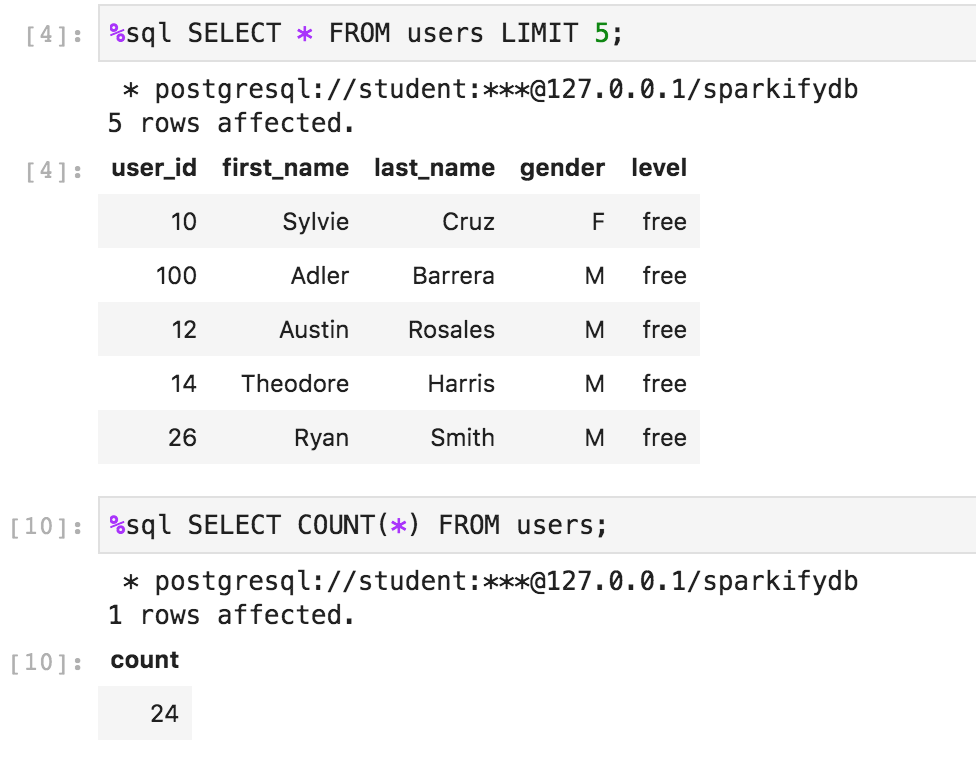

In [167]:
# verify via test.ipynb and display output

Image(filename='images/etl_users_insert_all_confirmation.png', width=500)

## #5: `songplays` Table
#### Extract Data and Songplays Table
This one is a little more complicated since information from the songs table, artists table, and original log file are all needed for the `songplays` table. Since the log file does not specify an ID for either the song or the artist, you'll need to get the song ID and artist ID by querying the songs and artists tables to find matches based on song title, artist name, and song duration time.
- Implement the `song_select` query in `sql_queries.py` to find the song ID and artist ID based on the title, artist name, and duration of a song.
- Select the timestamp, user ID, level, song ID, artist ID, session ID, location, and user agent and set to `songplay_data`

#### Insert Records into Songplays Table
- Implement the `songplay_table_insert` query and run the cell below to insert records for the songplay actions in this log file into the `songplays` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `songplays` table in the sparkify database.

In [168]:
log_df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Celeste,F,0,Williams,NaN,free,"Klamath Falls, OR",GET,Home,1.541078e+12,438,None,200,1541990217796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
1,Pavement,Logged In,Sylvie,F,0,Cruz,99.16036,free,"Washington-Arlington-Alexandria, DC-VA-MD-WV",PUT,NextSong,1.540266e+12,345,Mercy:The Laundromat,200,1541990258796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
2,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Logged In,Celeste,F,1,Williams,277.15873,free,"Klamath Falls, OR",PUT,NextSong,1.541078e+12,438,Horn Concerto No. 4 in E flat K495: II. Romanc...,200,1541990264796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
3,Gary Allan,Logged In,Celeste,F,2,Williams,211.22567,free,"Klamath Falls, OR",PUT,NextSong,1.541078e+12,438,Nothing On But The Radio,200,1541990541796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",53
4,None,Logged In,Jacqueline,F,0,Lynch,NaN,paid,"Atlanta-Sandy Springs-Roswell, GA",GET,Home,1.540224e+12,389,None,200,1541990714796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",29


In [169]:
# display songplay insert statement (to verify columns)
songplay_table_insert

'\n    INSERT INTO songplays (start_time, user_id, level, song_id, artist_id, session_id, location, user_agent)\n    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)\n    ON CONFLICT DO NOTHING;\n'

In [170]:
# display song_select query
song_select

'SELECT songs.song_id, artists.artist_id FROM songs \nJOIN artists ON songs.artist_id=artists.artist_id\nWHERE songs.title=%s \nAND artists.name=%s \nAND songs.duration=%s'

In [171]:
# counter
log_records_checked = 0

for index, row in next_song_df.iterrows():
    # get songid and artistid from song and artist tables
    cur.execute(song_select, (row.song, row.artist, row.length))
    results = cur.fetchone()
    log_records_checked += 1

    if results:
        songid, artistid = results
    else:
        songid, artistid = None, None 

    # insert songplay record if there is a matching song between log file and songs table
    rows_inserted = 0
    if songid:
        songplay_data = (row.ts, row.userId, row.level, songid, artistid, row.sessionId, row.location, row.userAgent)
        cur.execute(songplay_table_insert, songplay_data)
        conn.commit()
        rows_inserted += 1
        print('row inserted: {}'.format(songplay_data))

# verify records checked vs. inserted        
print('\n---------\nlog records checked = {}'.format(log_records_checked))
print('total rows inserted = {}'.format(rows_inserted))


---------
log records checked = 166
total rows inserted = 0


Run `test.ipynb` to see if you've successfully added records to this table. &mdash; NOT COMPLETED
#### **NOTE:**
After much troubleshooting and research, I confirmed that none of the songs in the first log file match any of the songs in the song files (and in turn, the `songs` table). This appears to be an error in the project setup and/or instructions provided by Udacity as recognized [here in the forum](https://knowledge.udacity.com/questions/37605). Perhaps one of the other log files contains matching songs. Testing this requires you to loop through all of the log files &mdash; which we'll do in the next step when creating `etl.py`.

For now, the cell above shows that zero matching records are found even if you only match on `songs.title` = `row.song`.

In the cell below, I confirm that I'm able to find matching records in `songs.title` when given a valid song title.

In [172]:
for index, row in next_song_df.iterrows():
    # get songid and artistid from song and artist tables
    cur.execute("SELECT * from songs WHERE songs.title='Setting Fire to Sleeping Giants'")
#     cur.execute("SELECT * from songs WHERE songs.title LIKE %s", (row.song,))
#     cur.execute(song_select, (row.song, row.artist, row.length))
    results = cur.fetchone()
    if results:
        print('\nresults = {}'.format(results))
        break


results = ('SOBBUGU12A8C13E95D', 'Setting Fire to Sleeping Giants', 'ARMAC4T1187FB3FA4C', 2004, 207.77751)


# Close Connection to Sparkify Database

In [123]:
conn.close()

# Implement `etl.py`
Use what you've completed in this notebook to implement `etl.py`.